# Ensembled Models I

In this notebook, we perform the exploration of different combinations of NLP and image models previously trained


In [1]:
import os
os.chdir('/home/app/src')
import time
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from utils import evaluation
from utils.build_df import build_df
from utils import tree_utils
from utils.text_normalizer import normalize_corpus
from utils.decoder import decode_id_path, decode_id

from utils import utils_img
from utils import efficientnet

%load_ext autoreload
%autoreload 2

2022-12-30 23:39:37.673372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 23:39:37.673421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Labels 



`build_df()` function returns a new dataset with custom leaf (label) according to the threshold of minimun amount of products selected per category.

Call `build_df()` to extract the labels 

In [2]:
cat = build_df(json_path='data/products.json', 
             threshold=100, 
             preprocessed_csv='data/normalized_data.csv'
            ) 

In [3]:
y = cat['leaf']

Recreating the hierarchical structure of our categories applying our `make_tree()` function.

We extracted the nodes from the same dataframe generated by `build_df()`. We are going to use it later to get the distance between predicted and true categories when apply `get_performance()` function  

In [4]:
tree_dict = tree_utils.make_tree(cat, cat['category'], 'Categories', display_tree= True)

Categories - All categories
├── pcmcat312300050015 - Connected Home & Housewares
│   ├── pcmcat248700050021 - Housewares
│   │   ├── pcmcat303600050001 - Household Batteries
│   │   └── pcmcat179100050006 - Outdoor Living
│   │       ├── pcmcat179200050003 - Grills
│   │       ├── pcmcat179200050008 - Patio Furniture & Decor
│   │       │   └── pcmcat748300322875 - Outdoor Seating
│   │       └── pcmcat179200050013 - Outdoor Heating
│   ├── abcat0802000 - Telephones & Communication
│   │   ├── abcat0811011 - Telephone Accessories
│   │   └── abcat0802001 - Cordless Telephones
│   │       └── pcmcat159300050002 - Systems
│   ├── abcat0805000 - Office Electronics
│   │   └── abcat0511001 - Printers, Ink & Toner
│   │       └── pcmcat266500050030 - All Printers
│   ├── pcmcat275600050000 - Office & School Supplies
│   │   └── abcat0807000 - Printer Ink & Toner
│   │       ├── abcat0807001 - Printer Ink
│   │       ├── pcmcat335400050008 - 3D Printer Filament
│   │       └── abcat0807009 -

## 2. Features

We took already normalized dataset (see `model_training/NLP_models/NB0_data_set_prep_and_training.ipynb` tutorial notebook)

In [5]:
df = pd.read_csv('data/normalized_data.csv')
df.head()

,name,description,nm_and_desc,category,image,name_and_description
0,duracel aaa batteri 4pack,compat select electron devic aaa size duralock...,Duracell - AAA Batteries (4-Pack) Compatible w...,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",http://www.bestbuy.com/site/duracell-aaa-batte...,duracel aaa batteri 4pack compat select electr...
1,duracel aa 15v coppertop batteri 4pack,longlast energi duralock power preserv technol...,Duracell - AA 1.5V CopperTop Batteries (4-Pack...,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",http://www.bestbuy.com/site/duracell-aa-1-5v-c...,duracel aa 15v coppertop batteri 4pack longlas...
2,duracel aa batteri 8pack,compat select electron devic aa size duralock ...,Duracell - AA Batteries (8-Pack) Compatible wi...,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",http://www.bestbuy.com/site/duracell-aa-batter...,duracel aa batteri 8pack compat select electro...
3,energ max batteri aa 4pack,4pack aa alkalin batteri batteri tester includ,Energizer - MAX Batteries AA (4-Pack) 4-pack A...,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",http://www.bestbuy.com/site/energizer-max-batt...,energ max batteri aa 4pack 4pack aa alkalin ba...
4,duracel c batteri 4pack,compat select electron devic c size duralock p...,Duracell - C Batteries (4-Pack) Compatible wit...,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",http://www.bestbuy.com/site/duracell-c-batteri...,duracel c batteri 4pack compat select electron...


As our NLP model can be trained on different features (names, description and concatenated name and description see model trainning notebooks) we can select from the following options:

In [6]:
name = df['name'].apply(str)
description = df['description'].apply(str)
name_and_description = df['name_and_description'].apply(str)
image = df['image']

## 2. First NLP Model: trained with names of products (BL0)



### 2.1. Feature selection

In [7]:
X_0 = name

### 2.2. Train/Test split

In [8]:
X_0_train, X_0_test, y_train, y_test = train_test_split(
    X_0, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

In [9]:
X_0_train.head()

7029                conair suprem 2in1 hot air brush white
26164    hp slimlin desktop intel pentium 4gb memori 50...
46217    mb quart discu 1200w class sq ab bridgeabl 2ch...
13187                  sabr window glass alarm 2pack white
41483                   elit beat agent preown nintendo ds
Name: name, dtype: object

### 2.3. Feature engineering

In [10]:
tfid_vectorizer_BL0 = TfidfVectorizer(max_features=5000,
                                      ngram_range=(1, 3),
                                      use_idf=False,
                                     ) 
tfid_vectorizer_BL0.fit(X_0_train)
#joblib.dump(tfid_vectorizer_BL0, '/home/app/src/model/vect_BL0')

TfidfVectorizer(max_features=5000, ngram_range=(1, 3), use_idf=False)

In [11]:
X_0_train = tfid_vectorizer_BL0.transform(X_0_train)
X_0_test = tfid_vectorizer_BL0.transform(X_0_test)

In [12]:
X_0_train[0]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

### 2.4. Modelling

In [13]:
logreg_BL0 = LogisticRegression(max_iter=7000, 
                            n_jobs=-1, 
                            multi_class='multinomial', 
                            solver='newton-cg',
                            random_state=42)

In [14]:
logreg_BL0.fit(X_0_train, y_train)

LogisticRegression(max_iter=7000, multi_class='multinomial', n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [15]:
# save the model 
# filename = '/home/app/src/model/model_BL0'
# joblib.dump(logreg_BL0, filename)

In [16]:
# getting predictions
y_pred_0 = logreg_BL0.predict(X_0_test)
y_pred_0.shape

(10330,)

In [17]:
y_pred_0_prob = logreg_BL0.predict_proba(X_0_test)

### 2.5. General evaluation

In [18]:
evaluation.get_performance(model=logreg_BL0,
                           pred_labels=y_pred_0, 
                           true_labels= y_test,
                           vectorizer=tfid_vectorizer_BL0,
                           probs=y_pred_0_prob,
                           average='micro',
                           tree= tree_dict)

Model Performance metrics:
------------------------------
Accuracy: 0.8191674733785091
Precision: 0.8191674733785091
Recall: 0.8191674733785091
F1 Score: 0.8191674733785091
Average distance between nodes categories: 0.40609874152952563
Top 5 Score: 0.9613746369796708

Model Classification report:
------------------------------
                                           precision    recall  f1-score   support

                      3D Printer Filament       0.89      1.00      0.94        47
                  A/V Cables & Connectors       0.68      0.81      0.74        90
                  Action Camcorder Mounts       0.59      0.61      0.60        28
           Activity Trackers & Pedometers       0.94      0.85      0.89        39
              Adapters, Cables & Chargers       0.66      0.72      0.69        71
                         Air Conditioners       1.00      0.96      0.98        28
             Air Purifier Filters & Parts       0.94      0.81      0.87        21
      

In [19]:
acc_BL_0 = round(accuracy_score(y_test, y_pred_0), 4)
top_5_acc_BL_0 = round(top_k_accuracy_score(y_test, y_pred_0_prob, k= 5), 4)

## 3. Second NLP Model: trained with concatenation of name and description of products (BL1)

### 3.1. Feature selection 

In [20]:
X_1 = name_and_description
X_1.head()

0    duracel aaa batteri 4pack compat select electr...
1    duracel aa 15v coppertop batteri 4pack longlas...
2    duracel aa batteri 8pack compat select electro...
3    energ max batteri aa 4pack 4pack aa alkalin ba...
4    duracel c batteri 4pack compat select electron...
Name: name_and_description, dtype: object

### 3.2. Train/Test split

In [21]:
X_1_train, X_1_test, y_train, y_test = train_test_split(
    X_1, y,
    test_size=0.20, 
    random_state=42,
    stratify = y
)

In [22]:
X_1_train.head()

7029     conair suprem 2in1 hot air brush white 150 wat...
26164    hp slimlin desktop intel pentium 4gb memori 50...
46217    mb quart discu 1200w class sq ab bridgeabl 2ch...
13187    sabr window glass alarm 2pack white sabr windo...
41483    elit beat agent preown nintendo ds prepar rock...
Name: name_and_description, dtype: object

### 3.3. Feature engineering

In [23]:
tfid_vectorizer_BL1 = TfidfVectorizer(max_features=3000,
                                  ngram_range=(1, 2),
                                  use_idf=False,
                                  min_df=1,
                                  norm='l2',
                                  smooth_idf=True
                                 )

In [24]:
tfid_vectorizer_BL1.fit(X_1_train)
#joblib.dump(tfid_vectorizer_BL1, '/home/app/src/model/vect_BL1')

TfidfVectorizer(max_features=3000, ngram_range=(1, 2), use_idf=False)

In [25]:
X_1_train = tfid_vectorizer_BL1.transform(X_1_train)
X_1_test = tfid_vectorizer_BL1.transform(X_1_test)

In [26]:
X_1_train[0]

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in Compressed Sparse Row format>

### 3.4. Modelling

In [27]:
logreg_BL1 = LogisticRegression(max_iter=2500, 
                            n_jobs=-1, 
                            multi_class='multinomial', 
                            solver='newton-cg',
                            random_state=42)

In [28]:
logreg_BL1.fit(X_1_train, y_train)

LogisticRegression(max_iter=2500, multi_class='multinomial', n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [29]:
# save the model to disk
# filename = '/home/app/src/model/model_BL1'
# joblib.dump(logreg_BL1, filename)

In [30]:
y_pred_1 = logreg_BL1.predict(X_1_test)

In [31]:
y_pred_1_prob = logreg_BL1.predict_proba(X_1_test)

### 3.5. General evaluation

In [32]:
evaluation.get_performance(model=logreg_BL1,
                           pred_labels=y_pred_1, 
                           true_labels=y_test,
                           vectorizer=tfid_vectorizer_BL1,
                           probs=y_pred_1_prob,
                           average='micro',
                           tree= tree_dict)

Model Performance metrics:
------------------------------
Accuracy: 0.8207163601161666
Precision: 0.8207163601161666
Recall: 0.8207163601161666
F1 Score: 0.8207163601161666
Average distance between nodes categories: 0.3940948693126815
Top 5 Score: 0.965053242981607

Model Classification report:
------------------------------
                                           precision    recall  f1-score   support

                      3D Printer Filament       0.87      1.00      0.93        47
                  A/V Cables & Connectors       0.68      0.84      0.76        90
                  Action Camcorder Mounts       0.64      0.75      0.69        28
           Activity Trackers & Pedometers       0.95      0.95      0.95        39
              Adapters, Cables & Chargers       0.67      0.73      0.70        71
                         Air Conditioners       0.96      0.96      0.96        28
             Air Purifier Filters & Parts       1.00      0.86      0.92        21
        

In [33]:
acc_BL_1 = round(accuracy_score(y_test, y_pred_1), 4)
top_5_acc_BL_1 = round(top_k_accuracy_score(y_test, y_pred_1_prob, k= 5), 4)

## 4. Computer Vision Model: model trained with image of the products

**TO-REVISE REFERENCE** 

The image model trained on (samples) using to see further details see ....

```python
#configurations of the model are saved in yaml file 
CONFIG_YML = "/home/app/src/model/exp4.yml"

# folder where the image to get prediction is
IMG = "/home/app/src/some_image_folder/"

# saved weights of the trained model
WEIGHTS = "/home/app/src/model/model.06-2.0593.h5"

#way to load the configurations 
config = utils_img.load_config(CONFIG_YML)

# classes to be predicted
MODEL_CLASSES = utils_img.get_class_names(config)

#load model
cnn_model = efficientnet.create_model(weights=WEIGHTS)

#getting predictions
predictions, labels, probs = utils_img.predict_from_folder(
    folder=IMG, 
    model=cnn_model, 
    input_size=config["data"]["image_size"], 
    class_names=MODEL_CLASSES,
)

In the seventh section we are going to get predictions of our ensembled model 

In [34]:
acc_cv_model = 0.6102
top_5_acc_cv_model = 0.8203

----------------------------------------------------------------------

## 5. Model Ensembling


In the next section, we explore different combinations of models. Given the difference in the dataset of images and text (caused by gif and invalid URL), it is not possible to make a direct comparison between the predicted probabilities by the different kinds of models - NLP and images. However, given that our main focus is on NLP models we can do such a comparison between both NLP models. On the basis of such comparison, we are going to select the best ensembled model 

### 5.1. Model A: weighted average ensembled model 

**TO-REVISE** average of predicted probabilities given by previous models

First way to combine models in order to get predictions is by making an average of the predicted probability for each label. 

In this case same weight to the probabillity of each model, that is:

$$ w_{n} + w_{d} + w_{i} = 1 $$
with $$ w_{n} = w_{d} = w_{i} $$

were $w_{n}$, $w_{d}$ and $w_{i}$ are the weights for the probability per sample given by the name model (BL0), the name and description model (BL1) and the image model respectively

$$ P(x) = p_{n}(x)  w_{n}  + p_{d}(x)  w_{d} + p_{i}(x)  w_{i}$$ 

In [35]:
# average model 

y_pred_emA_prob = np.array([((p1 + p2) * 0.5)for p1, p2 in zip(y_pred_0_prob, y_pred_1_prob)])

In [36]:
top_5_acc_emA = round(top_k_accuracy_score(y_test,y_pred_emA_prob, k=5), 4)

print(f""" 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_A
---------------------------------------------
{top_5_acc_BL_0}        |{top_5_acc_BL_1}        | {top_5_acc_emA}
---------------------------------------------
Improvement of {round((top_5_acc_emA - top_5_acc_BL_1)*100, 2)} % respect to the best NLP model

""")


 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_A
---------------------------------------------
0.9614        |0.9651        | 0.9707
---------------------------------------------
Improvement of 0.56 % respect to the best NLP model




### 5.2. Ensembled Model B: weighted maximum probabilities ensembled model 

max of predicted probabilities given by previous models

First way to combine models in order to get predictions is by making an average of the predicted probability for each label. 

In this case same weight to the probabillity of each model, that is:

$$ w_{n} + w_{d} + w_{i} = 1 $$
with $ w_{n} = w_{d} = w_{i} $

were $w_{n}$, $w_{d}$ and $w_{i}$ are the weights for the probability per sample given by the name model (BL0), the name and description model (BL1) and the image model respectively. In this second model we do not take the average but the maximun between the probability assigned for each model

$$ P_{emB}(x) = max(p_{n}(x)  w_{n}  , p_{d}(x)  w_{d} , p_{i}(x)  w_{i})$$ 

In [37]:
y_pred_emB_prob = np.maximum(y_pred_0_prob, y_pred_1_prob)

In [38]:
top_5_acc_emB = round(top_k_accuracy_score(y_test,y_pred_emB_prob, k=5), 4)

print(f""" 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_B
---------------------------------------------
{top_5_acc_BL_0}        |{top_5_acc_BL_1}        | {top_5_acc_emB}
---------------------------------------------
Improvement of {round((top_5_acc_emB - top_5_acc_BL_1)*100, 2)} % respect to the best NLP model

""")

 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_B
---------------------------------------------
0.9614        |0.9651        | 0.9687
---------------------------------------------
Improvement of 0.36 % respect to the best NLP model




### 5.3. Ensembled Model C: weighted scoring probabilities ensembled model

Third way to combine models in order to get predictions is by making a ponderation of the predicted probability for each label based on its accuracy score.

In this case the weight to the probabillity of each model is given by the following formulas:

$$ w_{n} = \frac{sc_{n}}{sc_{n} + sc_{d} + sc_{i}}$$

$$ w_{d} = \frac{sc_{d}}{sc_{n} + sc_{d} + sc_{i}}$$

$$ w_{i} = \frac{sc_{i}}{sc_{n} + sc_{d} + sc_{i}}$$


where $sc_{n}$ , $sc_{d}$  and $sc_{i}$ correspond to the accuracy of the name model (BL0), the name and description model (BL1) and the image model respectively.

In this third ensembled model we do not take the average but the maximun between the probability assigned for each model according to their weigths

$$ P_{emC}(x) = max(p_{n}(x)  w_{n}  , p_{d}(x)  w_{d} , p_{i}(x)  w_{i})$$ 



In [39]:
acc_name = acc_BL_0
acc_desc = acc_BL_1


wn = acc_name / (acc_name + acc_desc)
wd = acc_desc / (acc_name + acc_desc)


y_pred_emC_prob = np.maximum(np.array([p1 * wn for p1 in y_pred_0_prob]), 
                           np.array([p2 * wd for p2 in y_pred_1_prob]))

In [40]:
top_5_acc_emC = round(top_k_accuracy_score(y_test,y_pred_emC_prob, k=5), 4)

print(f""" 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_C
---------------------------------------------
{top_5_acc_BL_0}        |{top_5_acc_BL_1}        | {top_5_acc_emC}
---------------------------------------------
Improvement of {round((top_5_acc_emC - top_5_acc_BL_1)*100, 2)} % respect to the best NLP model

""")

 
         TOP FIVE ACCURACY SCORE
---------------------------------------------
NLP BL0       | NLP BL1      |NLP ENSEMBLED_C
---------------------------------------------
0.9614        |0.9651        | 0.9687
---------------------------------------------
Improvement of 0.36 % respect to the best NLP model




### 5.4. Ensembled Model Selection

Based on the metrics of our NLP model we selected ensembled model A. Our next step is to create a class so we can obtain predictions from this ensembled model.

The following code is saved in the `combined_model_class.py` located at the model folder to be used for the API. Here, we display the code in order to show general metrics of our ensembled model and how it works 

In [41]:
import yaml
from model.scripts import utils

class Combined_Model:

    def predict_proba(self, X_list, estimators):
        """
        Predict probabilities of classes for samples in X.
        Parameters
        ----------
        X : list of array_like or sparse matrix of shape (n_samples, n_features)
            [X_name, X_description, X_image]
        estimators: list of pretrained models to be combined in the following order [name_model, name_description_model, image_model]
        Returns
        -------
        C : array, shape [n_samples]
            Predicted class label per sample.
        """

        if len(estimators) == 2:
            y_pred_model_1 = estimators[0].predict_proba(X_list[0])
            y_pred_model_2 = estimators[1].predict_proba(X_list[1])
            prob_cat = np.array(
                [
                    (prob1 + prob2) * (1 / len(estimators))
                    for prob1, prob2 in zip(y_pred_model_1, y_pred_model_2)
                ]
            )

        # NLP + images
        elif len(estimators) == 3:
            CONFIG_YML = "model/exp4.yml"
            config = utils.load_config(CONFIG_YML)

            y_pred_model_1 = estimators[0].predict_proba(X_list[0])
            y_pred_model_2 = estimators[1].predict_proba(X_list[1])

            _, _, probs = utils.predict_from_folder(
                folder=X_list[2],
                model=estimators[2],
                input_size=config["data"]["image_size"],
                class_names=estimators[0].classes_,
            )
            y_pred_model_3 = probs[0]
            
            
            prob_cat = np.array(
                [
                    (prob1 + prob2 + prob3) * (1 / len(estimators))
                    for prob1, prob2, prob3 in zip(
                        y_pred_model_1, y_pred_model_2, y_pred_model_3
                    )
                ]
            )
        return prob_cat

    def predict(self, X_list, estimators):
        pred_prob_cat = self.predict_proba(X_list, estimators)
        cat = np.argmax(pred_prob_cat, axis=1)
        
        classes = estimators[0].classes_
        name_cat_max = []
        
        for idx in cat:
            nm_cat = classes[idx]
            name_cat_max.append(nm_cat)
        return np.array(name_cat_max)


    
    def predict_best_five(self, X_list, estimators, max_k_feat):
        """
        Selects the k classes with highest probability for samples in X_list obtained from predict_proba() method .

        Parameters
        ----------
        X_list : list of array_like or sparse matrix of shape (n_samples, n_features)
            [X_name, X_description, X_image] to pass to predict_proba()
        estimators: list of pretrained models to be combined in the following order [name_model, name_description_model, image_model]
        Returns

        estimators : list List of models to be combined

        max_k_feat : int number of classes

        Return
        -------
        dict_max_feat: python dict dictionary with classes with highest probability

        """

        cat_prob = self.predict_proba(X_list, estimators)

        classes = estimators[0].classes_

        most_prob_cat_idx = np.argsort(-cat_prob[0])[:max_k_feat]
        name_cat_max = []

        for idx in most_prob_cat_idx:
            nm_cat = classes[idx]
            name_cat_max.append(nm_cat)

        dict_max_feat = {}
        for items in range(len(name_cat_max)):
            dict_max_feat[str(items)] = decode_id_path(name_cat_max[items])

        return dict_max_feat

    # The next method is used by the API in order avoid displaying the category "other" generated by the threshold applied when the data was processed and which does not contribute to the UX
    def predict_best_five_wo(self, X_list, estimators, max_k_feat):
        """
        Selects the k classes with highest probability for samples in X_list obtained from predict_proba() method excluding the label "other"

        Parameters
        ----------
        X_list : list of array_like or sparse matrix of shape (n_samples, n_features)
            [X_name, X_description, X_image] to pass to predict_proba()
        estimators: list of pretrained models to be combined in the following order [name_model, name_description_model, image_model]
        Returns

        estimators : list List of models to be combined

        max_k_feat : int number of classes

        Return
        -------
        dict_max_feat: python dict dictionary with classes with highest probability

        """

        cat_prob = self.predict_proba(X_list, estimators)

        classes = estimators[0].classes_

        most_prob_cat_idx = np.argsort(-cat_prob[0])[:max_k_feat + 1]
        name_cat_max = []

        for idx in most_prob_cat_idx:
            nm_cat = classes[idx]
            name_cat_max.append(nm_cat)
        
        #Delete label "other" if it is in the list of top probability predictions
        try:
            name_cat_max.remove("other")
        except ValueError:
            name_cat_max = name_cat_max[:max_k_feat]


        dict_max_feat = {}
        for items in range(len(name_cat_max)):
            dict_max_feat[str(items)] = decode_id_path(name_cat_max[items])

        return dict_max_feat

## 7. Getting predictions from our selected ensembled model (NLP)

### 7.1.Predictions on test set

In [42]:
ensem_model = Combined_Model()

In [43]:
y_pred_ensemb = ensem_model.predict(X_list=[X_0_test, X_1_test], 
                                    estimators=[logreg_BL0, logreg_BL1], 
                                    )

In [44]:
y_pred_ensemb_prob = ensem_model.predict_proba(X_list=[X_0_test, X_1_test], 
                                               estimators=[logreg_BL0, logreg_BL1])

### 7.2. General evaluaction 

In [45]:
evaluation.get_performance(model=None,
                           pred_labels=y_pred_ensemb, 
                           true_labels=y_test,
                           vectorizer=None,
                           probs=y_pred_ensemb_prob,
                           average='micro',
                           tree= tree_dict)

Model Performance metrics:
------------------------------
Accuracy: 0.8336882865440465
Precision: 0.8336882865440465
Recall: 0.8336882865440465
F1 Score: 0.8336882865440465
Average distance between nodes categories: 0.3702807357212004
Top 5 Score: 0.9706679574056147

Model Classification report:
------------------------------
                                           precision    recall  f1-score   support

                      3D Printer Filament       0.85      1.00      0.92        47
                  A/V Cables & Connectors       0.66      0.84      0.74        90
                  Action Camcorder Mounts       0.65      0.79      0.71        28
           Activity Trackers & Pedometers       0.97      0.92      0.95        39
              Adapters, Cables & Chargers       0.67      0.73      0.70        71
                         Air Conditioners       1.00      0.96      0.98        28
             Air Purifier Filters & Parts       1.00      0.86      0.92        21
       

### 7.3. predictions on new data

Here we are going to get some predictions from our ensembled model. 

The first sample is taken from the test dataset and corresponds to a Keyboard (musical instrument)

In [46]:
name_sample = "Casio - Portable Keyboard with 61 Touch-Sensitive Keys - Black/Silver "
descr_sample = "CASIO Portable Keyboard with 61 Touch-Sensitive Keys: MIDI and USB connectivity; 600 AHL keyboard voices; 180 rhythms; 152 songs; auto accompaniment"
name_descr_sample = name_sample + " " + descr_sample 
true_label_sample = 'Keyboards'


In [47]:
#normalization and vectorization of the name data
name_sample_n = normalize_corpus([name_sample])
name_sample_v= tfid_vectorizer_BL0.transform(name_sample_n)

In [48]:
#normalization and vectorization of the description data
name_descr_sample_n = normalize_corpus([name_descr_sample])
name_descr_sample_v= tfid_vectorizer_BL1.transform(name_descr_sample_n)

In [49]:
image_sample = "/home/app/src/model_evaluation/test_images/"

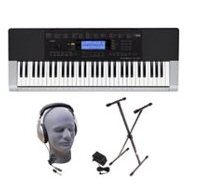

In [50]:
from IPython import display
display.Image("/home/app/src/model_evaluation/test_images/image.png")

In [51]:
#instantiating our ensembled model

model = Combined_Model()

In [52]:
# First NLP model
logreg_BL0

LogisticRegression(max_iter=7000, multi_class='multinomial', n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [53]:
# Second NLP model
logreg_BL1

LogisticRegression(max_iter=2500, multi_class='multinomial', n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [54]:
#image model
WEIGHTS = "/home/app/src/model/model.06-2.0593.h5"
cv_model = efficientnet.create_model(weights=WEIGHTS)

2022-12-30 23:45:21.410663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-30 23:45:21.410718: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-30 23:45:21.410753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (docker-desktop): /proc/driver/nvidia/version does not exist
2022-12-30 23:45:21.412641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
prediction = model.predict_best_five(X_list=[name_sample_v, name_descr_sample_v, image_sample], 
                                           estimators=[logreg_BL0, logreg_BL1, cv_model], 
                                           max_k_feat=5)

In [56]:
prediction

{'0': ['Musical Instruments', 'Keyboards'],
 '1': ['Computers & Tablets',
  'Computer Accessories & Peripherals',
  'Mice & Keyboards',
  'Computer Keyboards'],
 '2': ['Musical Instruments', 'Musical Instrument Accessories'],
 '3': ['other'],
 '4': ['Computers & Tablets', 'iPad & Tablet Accessories']}

Testing on new data. The secon sample corresponds to RAM memory kit available at different stores

In [57]:
name_sample2 = "Kingston Fury Beast 32GB (2x16GB) 4800MT/s DDR5 CL38 Kit of 2 Desktop Memory KF548C38BBK2-32, Black"
descr_sample2 = "Improved stablility for overclocking. Increased efficiency. Intel XMP 3.0-Ready and Certified Plug N Play at 4800MHz. Low-profile heat spreader design. System ram type: ddr5_sdram"
name_descr_sample2 = name_sample2 + " " + descr_sample2 

In [58]:
#normalization and vectorization of the name data
name_sample2_n = normalize_corpus([name_sample2])
name_sample2_v= tfid_vectorizer_BL0.transform(name_sample2_n)

In [59]:
#normalization and vectorization of the description data
name_descr_sample2_n = normalize_corpus([name_descr_sample2])
name_descr_sample2_v= tfid_vectorizer_BL1.transform(name_descr_sample2_n)

In [60]:
image_sample2 = "/home/app/src/model_evaluation/test_images/"

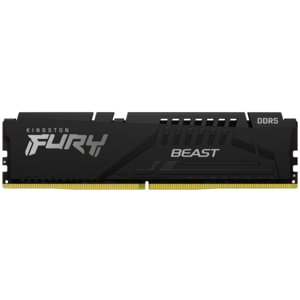

In [61]:
from IPython import display
display.Image("/home/app/src/model_evaluation/test_images/1645210727_hyperx.png")

In [64]:
prediction2 = model.predict_best_five(X_list=[name_sample2_v, name_descr_sample2_v, image_sample2], 
                                           estimators=[logreg_BL0, logreg_BL1, cv_model], 
                                           max_k_feat=5)

In [65]:
prediction2

{'0': ['Computers & Tablets', 'Computer Cards & Components'],
 '1': ['other'],
 '2': ['Appliances', 'Appliance Parts & Accessories'],
 '3': ['Health, Fitness & Beauty', 'Personal Care & Beauty', 'Hair Care'],
 '4': ['Car Electronics & GPS',
  'Car Installation Parts & Accessories',
  'Car Audio Installation Parts',
  'Deck Installation Parts',
  'Dash Installation Kits']}

-----------------------------------------------------------------------------------
This class is used for get predictions and performs evaluation of the model. For the evaluation see `/home/app/src/model_evaluation/ensemble_model_II.ipynb` notebook

